In [1]:
import numpy as np
import matplotlib.pyplot as plt
import datetime 
import os
import seaborn as sns
import itertools
import csv
from helpers import *
from helper_funcs import *
from plots import *
from implementations import *
from data_preprocessing import *

In [2]:
current_directory = os.getcwd()

data_path = os.path.join(current_directory, 'data')
x_train, x_test, y_train, train_ids, test_ids = load_csv_data(data_path, sub_sample=False)

In [3]:
#Saving the generated arrays in .npy files in order to have faster access to them
data_path = os.path.join(current_directory, 'convenient_data_format')

np.save(os.path.join(data_path, 'x_train.npy'), x_train)
np.save(os.path.join(data_path, 'x_test.npy'), x_test)
np.save(os.path.join(data_path, 'y_train.npy'), y_train)
np.save(os.path.join(data_path, 'train_ids.npy'), train_ids)
np.save(os.path.join(data_path, 'test_ids.npy'), test_ids)

In [4]:
# Open the file and read only the header
data_path = os.path.join(current_directory, 'data')
feature_names = np.genfromtxt(data_path+'/x_train.csv', delimiter=',', max_rows=1, dtype=str)[1:]

In [5]:
#Loading the arrays from the .npy files
data_path = os.path.join(current_directory, 'convenient_data_format')

x_train = np.load(os.path.join(data_path, 'x_train.npy'))
x_test = np.load(os.path.join(data_path, 'x_test.npy'))
y_train = np.load(os.path.join(data_path, 'y_train.npy'))
train_ids = np.load(os.path.join(data_path, 'train_ids.npy'))
test_ids = np.load(os.path.join(data_path, 'test_ids.npy'))

In [6]:
print('The train and test sets include N_train={} and N_test={} data samples and have D={} features.'.format(x_train.shape[0], x_test.shape[0], x_train.shape[1]))

The train and test sets include N_train=328135 and N_test=109379 data samples and have D=321 features.


In [7]:
## Determine the percentage of examples for which have data per feature 
N_per_feature = x_train.shape[0] - np.sum(np.isnan(x_train), axis = 0)
perc_N_per_feature = N_per_feature / x_train.shape[0]

perc_threshold = [0.7, 0.8, 0.90]
for perc in perc_threshold:
    print('Percentage of features for which examples have at least {} % of data (non-missing) = {} %'.format(100*perc, 
                                                                                                 100 * np.round(np.sum(perc_N_per_feature >= perc) / len(perc_N_per_feature),4)))

Percentage of features for which examples have at least 70.0 % of data (non-missing) = 44.86 %
Percentage of features for which examples have at least 80.0 % of data (non-missing) = 44.55 %
Percentage of features for which examples have at least 90.0 % of data (non-missing) = 43.3 %


In [8]:
## Explore the features for which 99 % of examples have (non missing) data
features_to_keep_logical = perc_N_per_feature > 0.90
feature_names[features_to_keep_logical]

array(['_STATE', 'FMONTH', 'IDATE', 'IMONTH', 'IDAY', 'IYEAR', 'DISPCODE',
       'SEQNO', '_PSU', 'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',
       'PERSDOC2', 'MEDCOST', 'CHECKUP1', 'BPHIGH4', 'BLOODCHO',
       'CVDSTRK3', 'ASTHMA3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',
       'HAVARTH3', 'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 'SEX', 'MARITAL',
       'EDUCA', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'CHILDREN', 'INCOME2',
       'INTERNET', 'WEIGHT2', 'HEIGHT3', 'QLACTLM2', 'USEEQUIP', 'BLIND',
       'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 'SMOKE100',
       'USENOW3', 'ALCDAY5', 'FRUITJU1', 'FRUIT1', 'FVBEANS', 'FVGREEN',
       'FVORANG', 'VEGETAB1', 'EXERANY2', 'STRENGTH', 'SEATBELT',
       'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 'QSTVER', 'QSTLANG', '_STSTR',
       '_STRWT', '_RAWRAKE', '_WT2RAKE', '_DUALUSE', '_LLCPWT', '_RFHLTH',
       '_HCVU651', '_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_CASTHM1',
       '_ASTHMS1', '_DRDXAR1', '_PRACE1', '_MRACE1', '_HISPANC', '_RACE',
       '_

In [9]:
x_train = x_train[:,features_to_keep_logical]
x_test = x_test[:,features_to_keep_logical]
feature_names = feature_names[features_to_keep_logical]

## Clean and preprocess data
1. Select features to keep
2. Fill missing values with mode (categorical) and median (continuous)  
3. Encode (categorical) and standardize (continuous) data

In [11]:
# Select features to keep 
'''
# features_to_keep = [
'GENHLTH', 'PHYSHLTH', 'MENTHLTH', 'HLTHPLN1',
'PERSDOC2', 'MEDCOST', 'CHECKUP1',
'CVDSTRK3', 'CHCSCNCR', 'CHCOCNCR', 'CHCCOPD1',
'ADDEPEV2', 'CHCKIDNY', 'DIABETE3', 
'SEX', 'MARITAL', 'RENTHOM1', 'VETERAN3', 'EMPLOY1', 'INTERNET', 
'QLACTLM2', 'USEEQUIP', 'BLIND', 'DECIDE', 'DIFFWALK', 'DIFFDRES', 'DIFFALON', 
'SMOKE100', 
'EXERANY2',
'FLUSHOT6', 'PNEUVAC3', 'HIVTST6', 
'_RFHYPE5', '_CHOLCHK', '_LTASTH1', '_DRDXAR1', 
'_MRACE1', '_HISPANC', '_RACEGR3', 
'_AGE80',
'HTM4', 
'WTKG3', '_BMI5CAT','_RFBMI5', 
'_CHLDCNT', '_EDUCAG', '_INCOMG', 
'_SMOKER3', 
'DROCDY3_', '_RFBING5','_RFDRHV5', 
'FTJUDA1_', 'FRUTDA1_', 'BEANDAY_', 'GRENDAY_','ORNGDAY_', 'VEGEDA1_','_FRUTSUM', '_FRTLT1', '_VEGLT1', 
'_TOTINDA', 'MAXVO2_', 'FC60_', 
'STRFREQ_', '_PACAT1', '_PAINDX1', '_PASTRNG', '_PAREC1', '_PASTAE1', 
'_LMTACT1','_LMTWRK1', '_LMTSCL1', 
'_RFSEAT2', '_RFSEAT3', 
'_AIDTST3']
'''

features_to_keep = []

In [12]:
# Clean and preprocess train and test data sets
x_train, feature_names_clean, continuous_features_idx, categorical_features_idx = clean_data(x_train, feature_names, features_to_keep)
x_test, _, _, _ = clean_data(x_test, feature_names, features_to_keep)
feature_names = feature_names_clean

In [13]:
# Save categorical and continuous features names
categorical_features = feature_names[categorical_features_idx]
continuous_features = feature_names[continuous_features_idx]

In [14]:
# Preprocess train and test data sets
x_train_cat_encoded, feature_cat_map, feature_cat_encoded_map, x_train_cont_stand, feature_cont_map, x_train_cont_mean, x_train_cont_std = preprocess_data(x_train, feature_names, categorical_features_idx, continuous_features_idx)
x_test_cat_encoded, _, _, x_test_cont_stand, _, x_test_cont_mean, x_test_cont_std = preprocess_data(x_test, feature_names, categorical_features_idx, continuous_features_idx)

In [15]:
def remove_duplicate_columns(data):
    # Transpose data for column-wise uniqueness check while preserving order
    data_t = data.T
    
    # Dictionary to track first occurrence of unique columns
    unique_columns, indices = np.unique(data_t, axis=0, return_index=True)
    
    # Sort indices to preserve the original order of columns
    sorted_indices = np.sort(indices)
    unique_values = data[:, sorted_indices]
    
    # Inverse mapping and counts
    _, unique_inverse, counts = np.unique(data_t, axis=0, return_inverse=True, return_counts=True)
    
    # Group duplicate column indices by their unique category
    duplicate_indices_grouped = [np.where(unique_inverse == i)[0].tolist() for i in range(len(counts)) if counts[i] > 1]

    return sorted_indices, duplicate_indices_grouped

In [16]:
unique_cat_indices, duplicate_indices_grouped = remove_duplicate_columns(x_train_cat_encoded)

In [17]:
x_train_cat_encoded = x_train_cat_encoded[:,unique_cat_indices]
x_test_cat_encoded = x_test_cat_encoded[:,unique_cat_indices]
feature_cat_map_unique =  feature_cat_map[unique_cat_indices]
feature_cat_encoded_map_unique = feature_cat_encoded_map[unique_cat_indices]

duplicate_cats = []
for dupl_list in duplicate_indices_grouped:
    dupl_idx = feature_cat_map[np.array(dupl_list).flatten()]
    duplicate_cats.append(categorical_features[dupl_idx])

feature_cat_map = feature_cat_map_unique
feature_cat_encoded_map = feature_cat_encoded_map_unique

duplicate_cats

[array(['EXERANY2', '_TOTINDA'], dtype='<U8'),
 array(['HIVTST6', '_AIDTST3'], dtype='<U8')]

In [18]:
# Select features 
n_comp_cat = int(x_train_cat_encoded.shape[1]*0.5)
n_comp_cont = int(x_train_cont_stand.shape[1]*0.5)
selected_cat_features_idx, selected_cont_features_idx = feature_selection(x_train_cat_encoded, x_train_cont_stand, n_comp_cat, n_comp_cont)
# selected_cat_features_idx = np.arange(x_train_cat_encoded.shape[1])
# selected_cont_features_idx = np.arange(x_train_cont_stand.shape[1])

In [19]:
# Keep only selected features, determine mapping between feature matrix and feature names
x_train_cat_encoded = x_train_cat_encoded[:,selected_cat_features_idx]
x_test_cat_encoded = x_test_cat_encoded[:,selected_cat_features_idx]
feature_cat_map =  feature_cat_map[selected_cat_features_idx]
feature_cat_encoded_map = feature_cat_encoded_map[selected_cat_features_idx]

x_train_cont_stand = x_train_cont_stand[:,selected_cont_features_idx]
x_test_cont_stand = x_test_cont_stand[:,selected_cont_features_idx]
feature_cont_map = feature_cont_map[selected_cont_features_idx]

In [20]:
if (np.size(x_train_cat_encoded) > 0) & (np.size(x_train_cont_stand) > 0):
    x_train_processed = np.hstack([x_train_cat_encoded, x_train_cont_stand])
    x_test_processed = np.hstack([x_test_cat_encoded, x_test_cont_stand])
elif (np.size(x_train_cat_encoded) > 0):
    x_train_processed = np.hstack([x_train_cat_encoded])
    x_test_processed = np.hstack([x_test_cat_encoded])
elif (np.size(x_train_cont_stand) > 0):
    x_train_processed = np.hstack([x_train_cont_stand])
    x_test_processed = np.hstack([x_test_cont_stand])

y_train_processed = np.where(y_train == 1, 1,0).reshape(-1,1)

In [21]:
print('The continuous features kept by feature selection are')
[item for item in continuous_features[feature_cont_map]]

The continuous features kept by feature selection are


['STRFREQ_',
 'FC60_',
 'MAXVO2_',
 '_FRUTSUM',
 'VEGEDA1_',
 'ORNGDAY_',
 'GRENDAY_',
 'BEANDAY_']

In [22]:
print('The categorical features kept by feature selection are')
[item for item in categorical_features[np.unique(feature_cat_map)]]

The categorical features kept by feature selection are


['_PAREC1',
 '_LMTSCL1',
 'HLTHPLN1',
 'MEDCOST',
 'CVDSTRK3',
 'CHCSCNCR',
 'CHCOCNCR',
 'CHCCOPD1',
 'ADDEPEV2',
 'CHCKIDNY',
 'SEX',
 'VETERAN3',
 'INTERNET',
 'QLACTLM2',
 'USEEQUIP',
 'BLIND',
 'DECIDE',
 'DIFFWALK',
 'DIFFDRES',
 'DIFFALON',
 'SMOKE100',
 'EXERANY2',
 'FLUSHOT6',
 'PNEUVAC3',
 'HIVTST6',
 '_RFHYPE5',
 '_CHOLCHK',
 '_LTASTH1',
 '_DRDXAR1',
 '_HISPANC',
 '_BMI5CAT',
 '_RFBMI5',
 '_RFBING5',
 '_RFDRHV5',
 '_FRTLT1',
 '_VEGLT1',
 '_PAINDX1',
 '_PASTRNG',
 '_PASTAE1',
 '_LMTACT1',
 '_LMTWRK1',
 '_RFSEAT2',
 '_RFSEAT3']

In [23]:
np.save(os.path.join(data_path, 'x_train_processed.npy'), x_train_processed)
np.save(os.path.join(data_path, 'x_test_processed.npy'), x_test_processed)
np.save(os.path.join(data_path, 'y_train_processed.npy'), y_train_processed)
np.save(os.path.join(data_path, 'categorical_features.npy'), categorical_features)
np.save(os.path.join(data_path, 'continuous_features.npy'), continuous_features)

In [24]:
x_train_processed = np.load(os.path.join(data_path, 'x_train_processed.npy'))
x_test_processed = np.load(os.path.join(data_path, 'x_test_processed.npy'))
y_train_processed = np.load(os.path.join(data_path, 'y_train_processed.npy'))
categorical_features = np.load(os.path.join(data_path, 'categorical_features.npy'))
continuous_features = np.load(os.path.join(data_path, 'continuous_features.npy'))

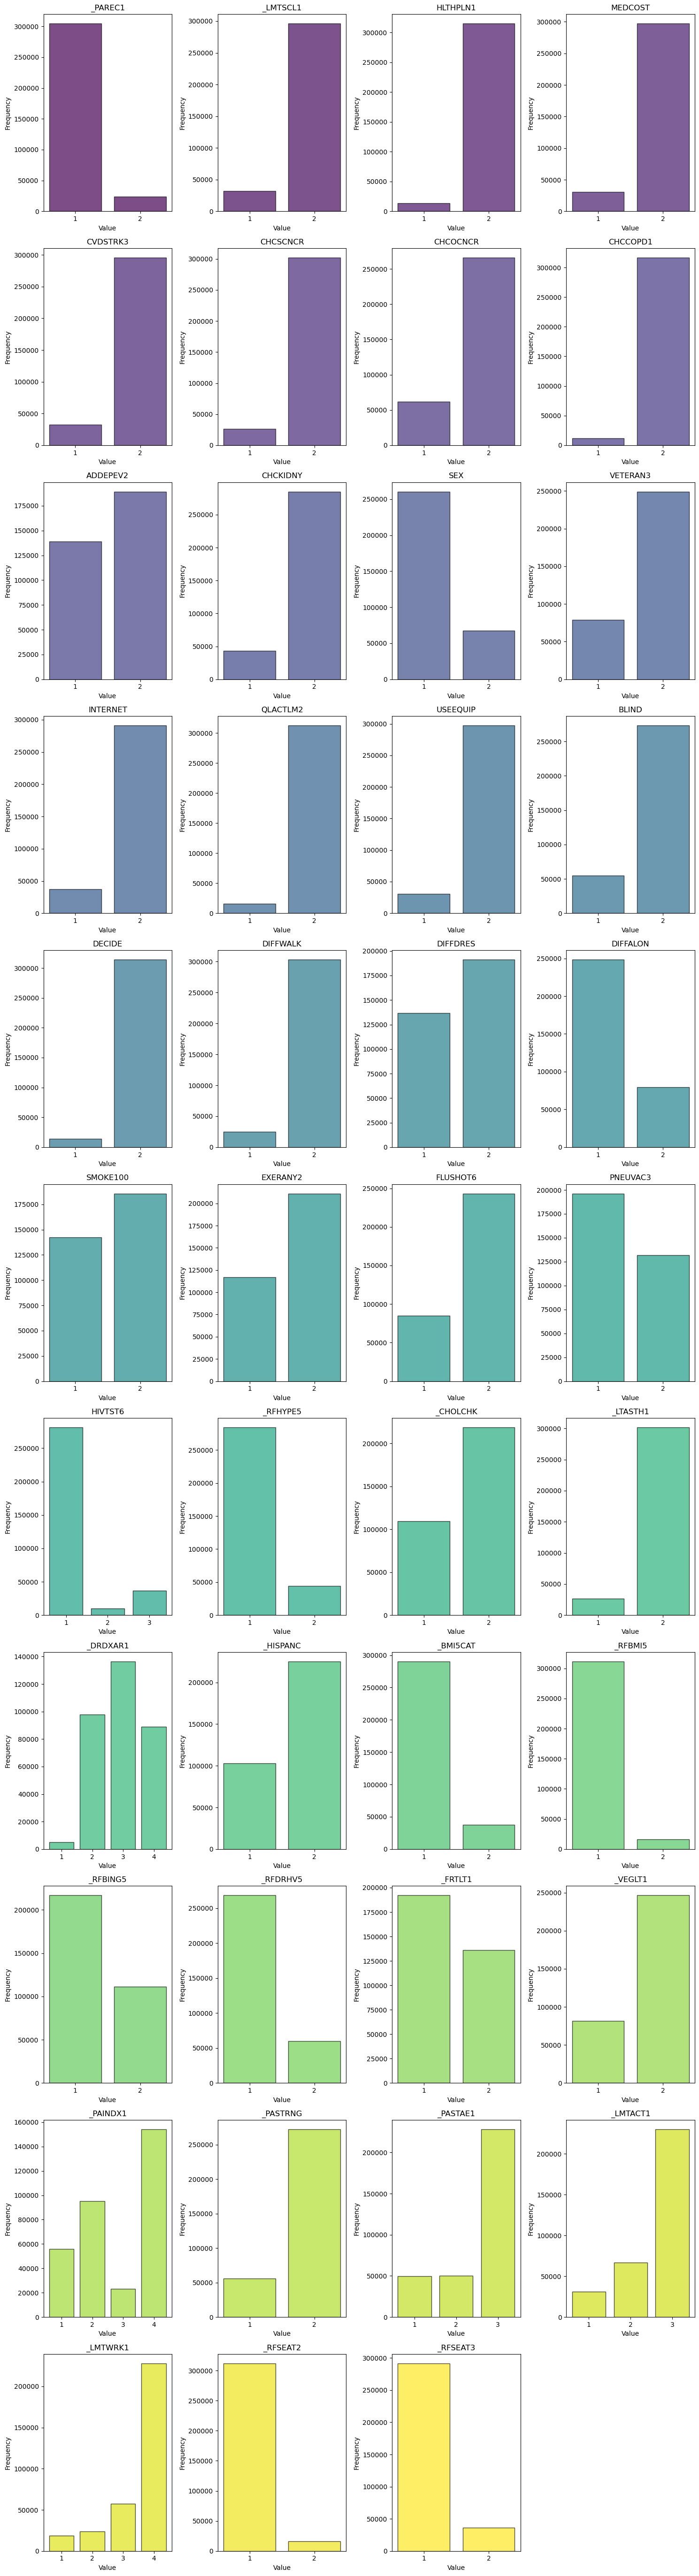

In [25]:
# Visualization of categorical features
features_list = [item for item in categorical_features[np.unique(feature_cat_map)]]
data = x_train[:, np.isin(feature_names, features_list)]
data_list = [data[:, col] for col in range(len(features_list))]
plot_histograms(data_list, features_list, num_cols=4)

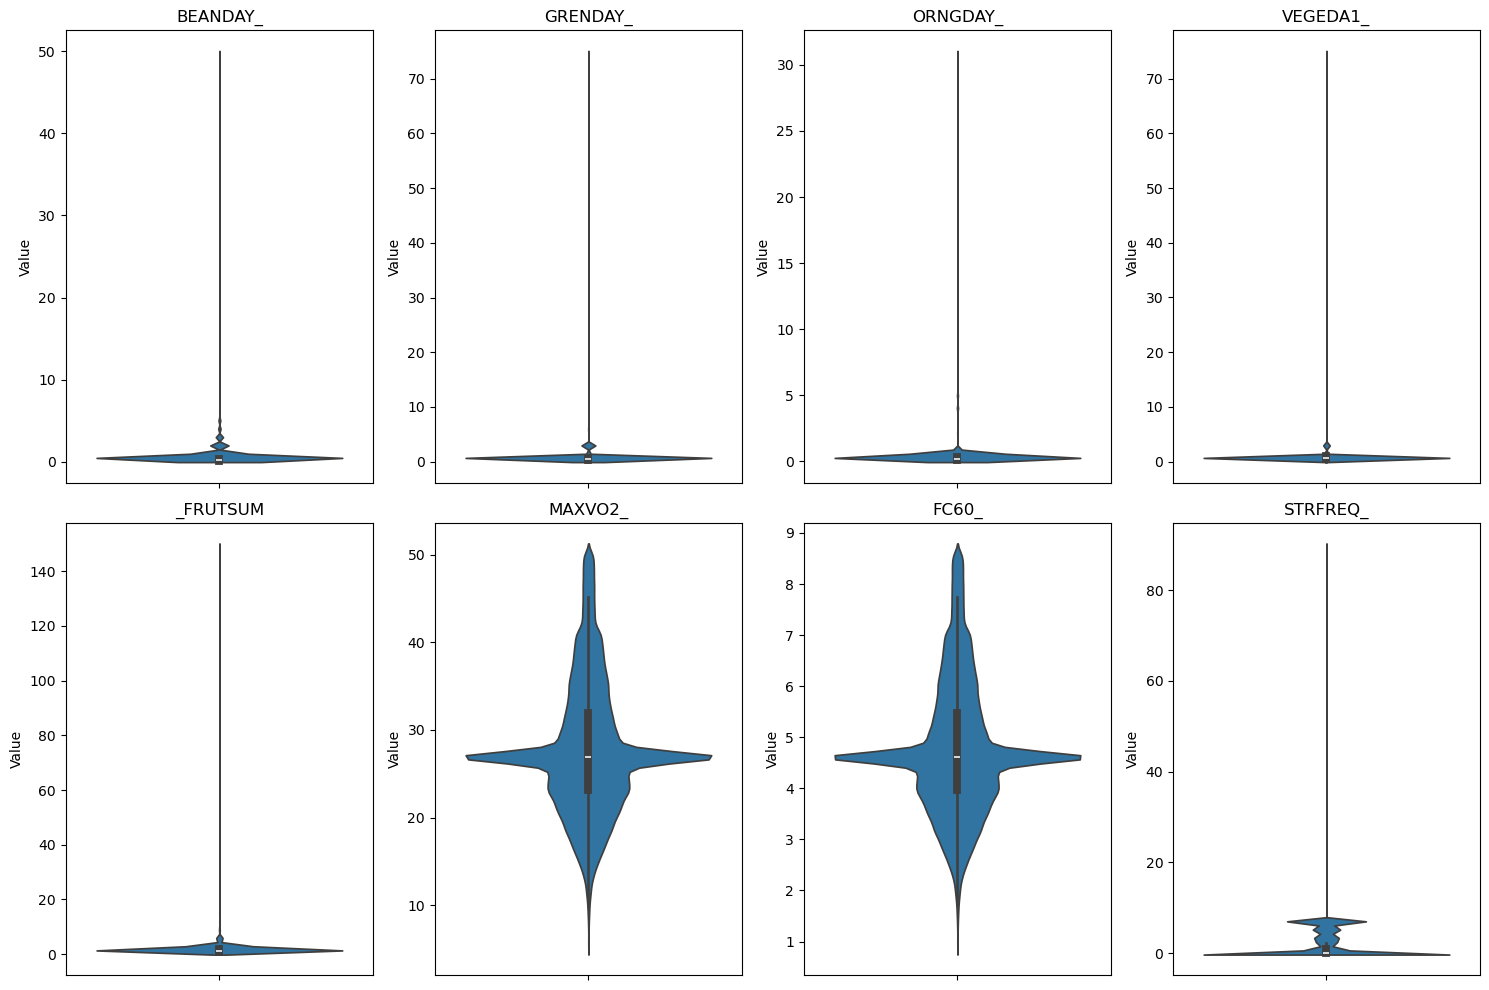

In [26]:
# Visualization of categorical features
features_list = [item for item in continuous_features[np.unique(feature_cont_map)]]
data = x_train[:, np.isin(feature_names, features_list)]
data_list = [data[:, col] for col in range(len(features_list))]
plot_violinplots(data_list, features_list, num_cols=4)

## Build model data
1. Add offset
2. Split train data into training and validation sets
3. Balance data 

In [28]:
# Add offset term
y_train, tx_train = build_model_data(y_train_processed, x_train_processed)
tx_test = np.c_[np.ones(x_test_processed.shape[0]), x_test_processed]

In [29]:
# Split data into train and validation sets
split_index = int(tx_train.shape[0] * 0.8)

np.random.seed(20)
indices = np.random.permutation(tx_train.shape[0])

# Split the indices for training and validation sets
train_indices = indices[:split_index]
validation_indices = indices[split_index:]

# Use the indices to split the data
tx_train_training = tx_train[train_indices,:]
tx_train_validation = tx_train[validation_indices,:]
y_train_training = y_train[train_indices]
y_train_validation = y_train[validation_indices]

In [30]:
# Balance data: undersample minority class
y_majority = y_train_training[y_train_training == 0]
y_minority = y_train_training[y_train_training == 1]
X_majority = tx_train_training[y_train_training.flatten() == 0, :]
X_minority = tx_train_training[y_train_training.flatten() == 1, :]

split_ratio = [0.2, 0.3, 0.4, 0.5]
tx_training_balanced_split = []
y_training_balanced_split = []
np.random.seed(21)
for s in split_ratio:
    # Keep all minority samples and balance majority samples based on the split ratio
    desired_majority_size = int(len(y_minority) * (1 - s) / s)
    
    # Randomly select `desired_majority_size` samples from the majority class
    majority_indices = np.random.choice(len(X_majority), desired_majority_size, replace=False)
    X_majority_undersampled = X_majority[majority_indices]
    y_majority_undersampled = y_majority[majority_indices]

    # Combine the full minority class with the undersampled majority class
    tx_training_balanced = np.vstack((X_minority, X_majority_undersampled))
    y_training_balanced = np.hstack((y_minority, y_majority_undersampled)).reshape((-1, 1))

    # Store the balanced data for each split ratio
    tx_training_balanced_split.append(tx_training_balanced)
    y_training_balanced_split.append(y_training_balanced)

In [31]:
# Execute optimization algorithm, save loss and w

f1_scores = []
for idx, s in enumerate(split_ratio):

    tx_training_balanced = tx_training_balanced_split[idx]
    y_training_balanced = y_training_balanced_split[idx]
    ls_loss, ls_w = least_squares(y_training_balanced, tx_training_balanced)

    y_pred = tx_train_validation.dot(ls_w)
    y_pred = np.where(y_pred > 0.5, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    f1_scores.append(f1_score)
    
    print('Least squares - Split ratio {:.2f}/{:.2f} , F1 score = {:.5f}'.format(s, 1-s, f1_score))

tx_training_balanced = tx_training_balanced_split[np.argmax(np.array(f1_scores))]
y_training_balanced = y_training_balanced_split[np.argmax(np.array(f1_scores))]

Least squares - Split ratio 0.20/0.80 , F1 score = 0.33354
Least squares - Split ratio 0.30/0.70 , F1 score = 0.38122
Least squares - Split ratio 0.40/0.60 , F1 score = 0.37798
Least squares - Split ratio 0.50/0.50 , F1 score = 0.34424


## Model selection and validation

The selected models are
- Gradient Descent with MSE loss function
- Stochastic Gradient Descent with MAE loss function
- Least squares 
- Regularized least squares
- Logistic regression
- Ridge logistic regression

they are evaluated on the metrics
- loss
- accuracy
- F1-score
- MSE
- R squared

and they are optimized over
- the learning rate - _iterative algorithms (GD, SGD)_
- the penalty - _regularized algorithms (ridge regression)_
- the training / validation split ratio 

##### Initialisation of the algorithm

In [34]:
# Define the parameters of the algorithms
max_iters = 100
learning_rate = np.linspace(0.01, 0.09, 9)
penalty = np.logspace(-4, 0, 5)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))
threshold = 0.5

#### Gradient Descent - MSE loss function

In [36]:
"""Gradient descent, mse loss function"""
# Iterate over learning rate parameter values 
gd_mse_f1_score = np.zeros(len(learning_rate))
gd_mse_rmse = np.zeros(len(learning_rate))

gd_mse_ws_var_gamma = []
gd_mse_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    gd_mse_losses, gd_mse_ws = mean_squared_error_gd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("GD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(gd_mse_ws[-1])
    y_pred = np.where(y_pred > threshold, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    gd_mse_f1_score[idx] = f1_score
    gd_mse_rmse[idx] = np.sqrt(mse)

    gd_mse_ws_var_gamma.append(gd_mse_ws[-1])
    gd_mse_losses_var_gamma.append(gd_mse_losses)
    

loss=0.08890403464763166
GD - mse: gamma=0.010, execution time=0.811 seconds 

loss=0.08627843578724839
GD - mse: gamma=0.020, execution time=0.636 seconds 

loss=0.08449357139673688
GD - mse: gamma=0.030, execution time=0.536 seconds 

loss=0.0833342979451175
GD - mse: gamma=0.040, execution time=0.599 seconds 

loss=0.0825140130330237
GD - mse: gamma=0.050, execution time=0.595 seconds 

loss=0.08181686754992233
GD - mse: gamma=0.060, execution time=0.557 seconds 

loss=0.08136953822755716
GD - mse: gamma=0.070, execution time=0.537 seconds 

loss=0.0810324446437253
GD - mse: gamma=0.080, execution time=0.535 seconds 

loss=0.0807780419623929
GD - mse: gamma=0.090, execution time=0.465 seconds 



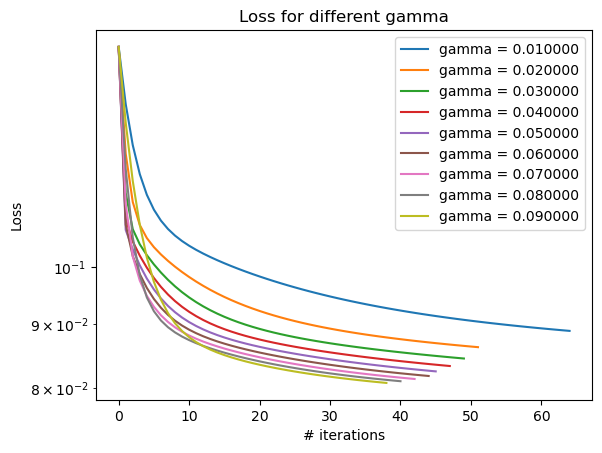

In [37]:
# Visualization
plot_loss_variable_param(gd_mse_losses_var_gamma, learning_rate, 'gamma')

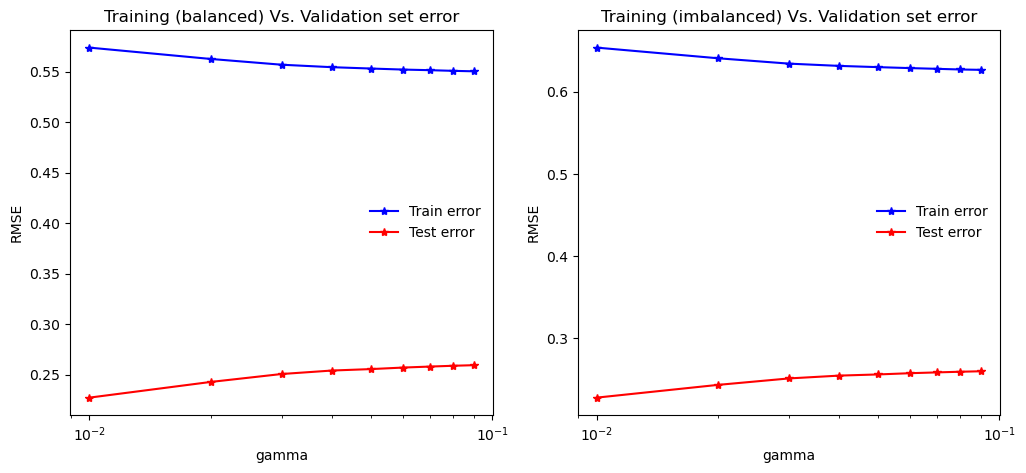

In [38]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = gd_mse_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, gd_mse_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [39]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([gd_mse_f1_score.reshape(-1,1), gd_mse_rmse.reshape(-1,1)])
metric_name = 'f1_score'

gd_mse_opt_idx = hyperparam_optimization(metric_name, metrics, gd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is gamma=0.090000 given optimization of the metric f1_score evaluating 0.31686.

The optimal weights are w = [[ 0.06388038]
 [ 0.01294781]
 [ 0.00998636]
 [-0.00185683]
 [ 0.01501684]
 [-0.00597276]
 [ 0.00251937]
 [ 0.0376121 ]
 [ 0.02954921]
 [ 0.01520963]
 [ 0.01122498]
 [ 0.01722568]
 [-0.00435206]
 [-0.00834095]
 [ 0.04228242]
 [ 0.03172825]
 [ 0.01055416]
 [ 0.01835946]
 [ 0.05210577]
 [-0.01791006]
 [ 0.035516  ]
 [-0.01165389]
 [-0.00676789]
 [ 0.1229939 ]
 [ 0.03244428]
 [-0.04276496]
 [ 0.00808746]
 [ 0.02063813]
 [-0.03264318]
 [ 0.00290828]
 [ 0.02335222]
 [-0.04595759]
 [ 0.00386071]
 [ 0.02061871]
 [-0.02353451]
 [-0.0529175 ]
 [ 0.05865462]
 [-0.00231023]
 [-0.05236293]
 [ 0.01602707]
 [ 0.00177398]
 [-0.0247302 ]
 [ 0.02345276]
 [ 0.0245534 ]
 [-0.01569028]
 [ 0.0288014 ]
 [ 0.00185877]
 [-0.00386369]
 [ 0.00248809]
 [ 0.01950169]
 [ 0.02070179]
 [ 0.00761089]
 [ 0.00929942]
 [ 0.01786472]
 [-0.05159316]
 [-0.05148309]
 [-0.00073088]
 [ 0.00027078]

In [40]:
highest_correlated_cat_feat, highest_correlated_cont_feat = highly_correlated_features(gd_mse_ws_var_gamma[gd_mse_opt_idx], feature_cat_map, feature_cont_map, categorical_features, continuous_features, duplicate_cats)
print('The categorical and continuous features with higher weights are respectively {}, {}.'.format(highest_correlated_cat_feat, highest_correlated_cont_feat))

The categorical and continuous features with higher weights are respectively _RFHYPE5, STRFREQ_.


#### Stochastic gradient descent - MSE loss function

In [42]:
"""Stochastic gradient descent, mse loss function"""
# Iterate over learning rate parameter values 

learning_rate = np.linspace(0.001, 0.1, 10)

sgd_mse_f1_score = np.zeros(len(learning_rate))
sgd_mse_rmse = np.zeros(len(learning_rate))

sgd_mse_ws_var_gamma = []
sgd_mse_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and weights at every iteration
    start_time = datetime.datetime.now()
    losses, ws = mean_squared_error_sgd(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("SGD - mse: gamma={g:.3f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(ws[-1])
    y_pred = np.where(y_pred > threshold, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    sgd_mse_f1_score[idx] = f1_score
    sgd_mse_rmse[idx] = np.sqrt(mse)

    sgd_mse_ws_var_gamma.append(ws[-1])
    sgd_mse_losses_var_gamma.append(losses)
    

loss=0.02292774768546971
SGD - mse: gamma=0.001, execution time=0.004 seconds 

loss=0.003205029667248346
SGD - mse: gamma=0.012, execution time=0.001 seconds 

loss=4.1798725462005e-06
SGD - mse: gamma=0.023, execution time=0.002 seconds 

loss=0.0012509596164774056
SGD - mse: gamma=0.034, execution time=0.002 seconds 

loss=0.001688642222997358
SGD - mse: gamma=0.045, execution time=0.021 seconds 

loss=0.07502042000558928
SGD - mse: gamma=0.056, execution time=0.003 seconds 

loss=20.766761385055027
SGD - mse: gamma=0.067, execution time=0.001 seconds 

loss=6076191.681484741
SGD - mse: gamma=0.078, execution time=0.001 seconds 

loss=21620992855.73099
SGD - mse: gamma=0.089, execution time=0.002 seconds 

loss=642797505345800.2
SGD - mse: gamma=0.100, execution time=0.006 seconds 



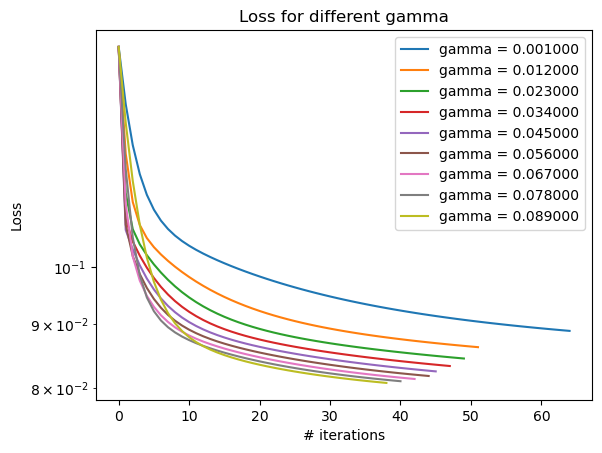

In [43]:
# Visualization
plot_loss_variable_param(gd_mse_losses_var_gamma, learning_rate, 'gamma')

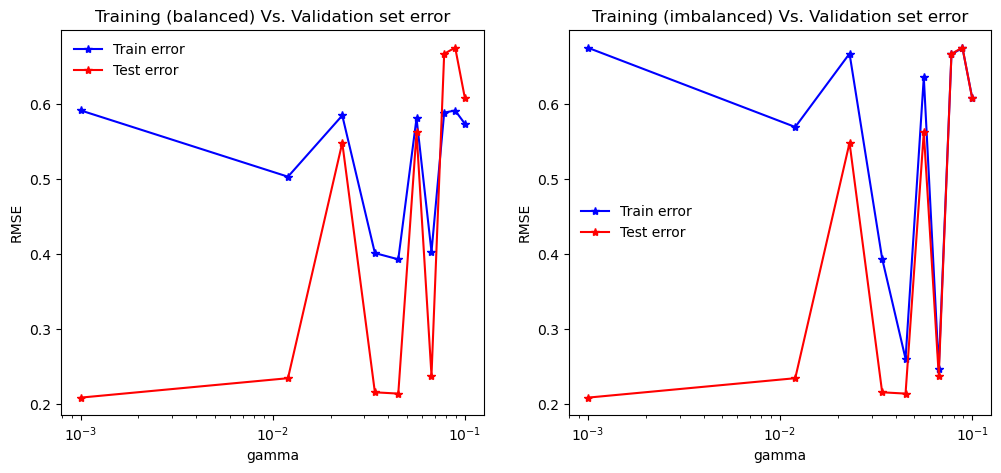

In [44]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = sgd_mse_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, sgd_mse_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [45]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([sgd_mse_f1_score.reshape(-1,1), sgd_mse_rmse.reshape(-1,1)])
metric_name = 'f1_score'

sgd_mse_opt_idx = hyperparam_optimization(metric_name, metrics, sgd_mse_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is gamma=0.023000 given optimization of the metric f1_score evaluating 0.20864.

The optimal weights are w = [[ 4.11370022e-02]
 [-5.18689083e-02]
 [ 4.75867445e-02]
 [-1.26397447e-02]
 [ 1.32468296e-01]
 [-1.26397447e-02]
 [ 3.93637694e-02]
 [ 4.24360392e-02]
 [ 6.73450469e-02]
 [ 3.97496350e-02]
 [ 3.14329677e-02]
 [-1.18697670e-02]
 [ 1.83224115e-03]
 [-2.74729214e-02]
 [ 2.07808109e-02]
 [ 5.09783596e-03]
 [ 1.56829750e-02]
 [ 8.81171604e-04]
 [ 8.80510015e-02]
 [-1.26397447e-02]
 [-5.96788493e-05]
 [-3.72742280e-02]
 [-1.93471681e-02]
 [ 1.09706115e-01]
 [ 6.58641462e-02]
 [-4.02784663e-02]
 [-3.26691273e-02]
 [ 7.09671776e-02]
 [-1.10926972e-02]
 [ 5.03305985e-02]
 [ 1.60954317e-02]
 [ 2.64104555e-02]
 [-9.17154986e-03]
 [ 5.27502386e-02]
 [ 7.34011552e-02]
 [ 1.54722248e-02]
 [-4.49590361e-02]
 [ 4.23578181e-02]
 [-3.99470519e-02]
 [ 6.90477862e-03]
 [-5.24918120e-02]
 [ 8.09613563e-03]
 [ 4.36231451e-02]
 [ 7.55455512e-03]
 [ 1.21257410e-02]
 [ 7.49199271e

In [46]:
highest_correlated_cat_feat, highest_correlated_cont_feat = highly_correlated_features(sgd_mse_ws_var_gamma[sgd_mse_opt_idx], feature_cat_map, feature_cont_map, categorical_features, continuous_features, duplicate_cats)
print('The categorical and continuous features with higher weights are respectively {}, {}.'.format(highest_correlated_cat_feat, highest_correlated_cont_feat))

The categorical and continuous features with higher weights are respectively _LMTWRK1, BEANDAY_.


#### Least squares

In [48]:
"""Least squares"""

# Execute optimization algorithm, save loss and w
start_time = datetime.datetime.now()
ls_loss, ls_w = least_squares(y_training_balanced, tx_training_balanced)
end_time = datetime.datetime.now()

# Print execution time 
execution_time = (end_time - start_time).total_seconds()
print("Least squares: execution time={t:.3f} seconds.\n\n".format(t=execution_time))

# Compute accuracy metrics
y_pred = tx_train_validation.dot(ls_w)
y_pred = np.where(y_pred > threshold, 1, 0)

tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
f1_score = 2*tp/(2*tp + fp + fn)
rmse = np.sqrt(calculate_mse(y_train_validation - y_pred))

print('The optimal weights are w = {}\n.'.format(ls_w))
print('f1 score = {f:.5f}, RMSE = {r:.5f}\n'.format(f=f1_score, r=rmse))
print('*******************************\n')
print_report(ls_w, False, tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test)


Least squares: execution time=0.037 seconds.


The optimal weights are w = [[ 1.09613449e+00]
 [ 9.89018885e-03]
 [ 1.65970054e-02]
 [-4.33190876e-03]
 [-3.13426907e-03]
 [-3.14913959e-02]
 [ 1.30142967e-02]
 [-1.19504664e+01]
 [ 4.73290676e-02]
 [-2.44477576e-02]
 [-3.52256964e-03]
 [ 2.30243630e-03]
 [-2.52647009e-02]
 [-3.79721438e-02]
 [ 5.59929456e+00]
 [-5.59548352e+00]
 [-5.60415413e+00]
 [-6.24601129e-03]
 [-1.84786939e-02]
 [-6.99254138e-02]
 [ 6.62269250e-03]
 [-4.18831546e-02]
 [-6.55092039e-02]
 [ 1.28979045e-01]
 [ 1.95159508e-02]
 [-7.37878623e-02]
 [-8.42620712e-04]
 [ 4.94729238e-03]
 [-4.04956391e-02]
 [-8.55500961e-03]
 [ 1.42517923e-02]
 [-6.07252421e-02]
 [-1.85973948e-02]
 [-4.71509435e-02]
 [-3.81725288e-02]
 [-4.84849292e-02]
 [ 4.56527200e-02]
 [-3.83829474e-02]
 [-1.15085677e-01]
 [-1.27604320e-01]
 [-1.19047904e-02]
 [-1.37039813e-01]
 [-1.94469615e-02]
 [-2.96179669e-02]
 [-2.27717317e-01]
 [-2.48237550e-02]
 [-2.97669376e-03]
 [ 6.89229255e-02]
 [-1.52826976

In [49]:
highest_correlated_cat_feat, highest_correlated_cont_feat = highly_correlated_features(ls_w, feature_cat_map, feature_cont_map, categorical_features, continuous_features, duplicate_cats)
print('The categorical and continuous features with higher weights are respectively {}, {}.'.format(highest_correlated_cat_feat, highest_correlated_cont_feat))

The categorical and continuous features with higher weights are respectively _PAREC1, MAXVO2_.


#### Ridge regression

In [51]:
"""Ridge regression"""

# Iterate over penalty parameter values
ridge_ls_loss = np.zeros(len(penalty))
ridge_ls_f1_score = np.zeros(len(penalty))
ridge_ls_rmse = np.zeros(len(penalty))

ridge_ls_ws_var_lambda = []

for idx, lambda_ in enumerate(penalty):

    # Execute optimization algorithm, save w 
    start_time = datetime.datetime.now()
    ridge_ls_losses, ridge_ls_ws = ridge_regression(y_training_balanced, tx_training_balanced, lambda_)
    end_time = datetime.datetime.now()

    # Print execution time 
    execution_time = (end_time - start_time).total_seconds()
    print("Ridge regression: lambda={l:.3f}, execution time={t:.3f} seconds \n".format(l=lambda_, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(ridge_ls_ws)
    y_pred = np.where(y_pred > threshold, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    ridge_ls_loss[idx] = ridge_ls_losses
    ridge_ls_f1_score[idx] = f1_score
    ridge_ls_rmse[idx] = np.sqrt(mse)

    ridge_ls_ws_var_lambda.append(ridge_ls_ws)
    

Ridge regression: lambda=0.000, execution time=0.061 seconds 

Ridge regression: lambda=0.001, execution time=0.043 seconds 

Ridge regression: lambda=0.010, execution time=0.049 seconds 

Ridge regression: lambda=0.100, execution time=0.022 seconds 

Ridge regression: lambda=1.000, execution time=0.034 seconds 



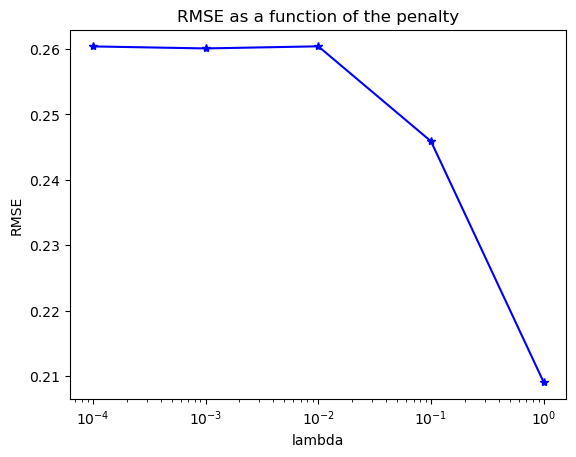

In [52]:
fig = plt.figure()
plt.semilogx(penalty, ridge_ls_rmse, color="b", marker="*")
plt.title("RMSE as a function of the penalty")
plt.xlabel("lambda")
plt.ylabel("RMSE")
plt.show()

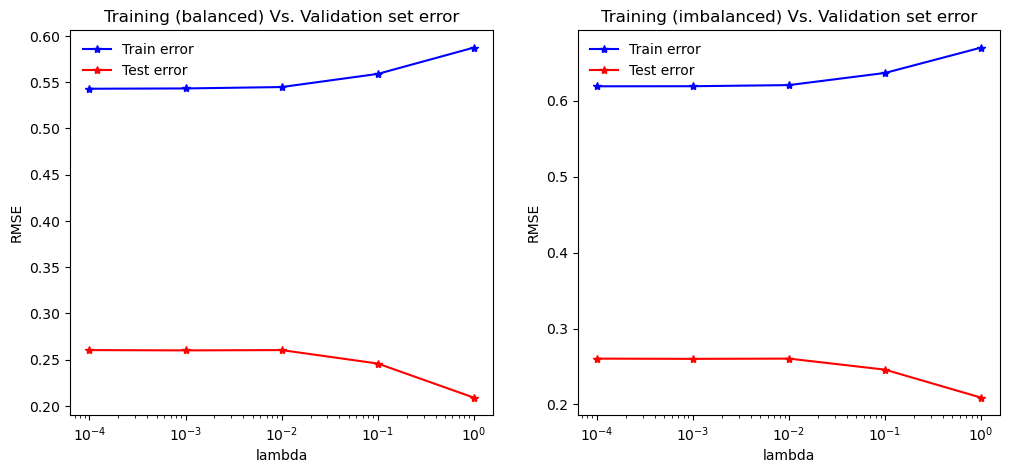

In [53]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = ridge_ls_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, ridge_ls_ws_var_lambda, penalty)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'lambda')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'lambda')

In [54]:
metrics = np.hstack([ridge_ls_f1_score.reshape(-1,1), ridge_ls_rmse.reshape(-1,1)])
metric_name = 'f1_score'

ridge_ls_opt_idx = hyperparam_optimization(metric_name, metrics, ridge_ls_ws_var_lambda, penalty, 'lambda', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, False)

The optimal parameter is lambda=0.000100 given optimization of the metric f1_score evaluating 0.38146.

The optimal weights are w = [[ 1.06052323e+00]
 [ 9.90604013e-03]
 [ 1.66275433e-02]
 [-2.69229077e-03]
 [-2.36033861e-03]
 [-2.92766813e-02]
 [ 1.31418795e-02]
 [-3.25025248e-03]
 [ 4.43122774e-02]
 [-2.42733368e-02]
 [-3.36461130e-03]
 [ 2.65309456e-03]
 [-2.50606043e-02]
 [-3.76700045e-02]
 [ 8.67745313e-03]
 [ 8.68234575e-03]
 [-4.89262184e-06]
 [ 7.25781178e-03]
 [-1.52247117e-02]
 [-6.96571550e-02]
 [ 7.91776814e-03]
 [-4.13204512e-02]
 [-6.47161208e-02]
 [ 1.29862099e-01]
 [ 1.96504455e-02]
 [-7.35816853e-02]
 [-3.32742154e-04]
 [ 5.43570616e-03]
 [-4.04215535e-02]
 [-8.76999530e-03]
 [ 1.60821201e-02]
 [-6.11752265e-02]
 [-1.89051803e-02]
 [-4.49765493e-02]
 [-3.80491847e-02]
 [-4.93267515e-02]
 [ 4.67002586e-02]
 [-3.72582201e-02]
 [-1.14622835e-01]
 [-1.23992668e-01]
 [-1.24685468e-02]
 [-1.35701873e-01]
 [-1.80625678e-02]
 [-2.78992337e-02]
 [-2.24860411e-01]
 [-2.35102823

In [55]:
highest_correlated_cat_feat, highest_correlated_cont_feat = highly_correlated_features(ridge_ls_ws_var_lambda[ridge_ls_opt_idx], feature_cat_map, feature_cont_map, categorical_features, continuous_features, duplicate_cats)
print('The categorical and continuous features with higher weights are respectively {}, {}.'.format(highest_correlated_cat_feat, highest_correlated_cont_feat))

The categorical and continuous features with higher weights are respectively _RFHYPE5, BEANDAY_.


#### Logistic regression

In [57]:
### AAA: Balance data

In [58]:
# Define the parameters of the algorithms
max_iters = 100
learning_rate = np.logspace(-4, -1, 4)
penalty = np.logspace(-6, 0, 7)

# Initialization
w_initial = np.zeros((tx_training_balanced.shape[1],1))
threshold = 0

In [59]:
"""Logistic regression - gradient descent"""
# Iterate over learning rate parameter values 
logistic_gd_f1_score = np.zeros(len(learning_rate))
logistic_gd_rmse = np.zeros(len(learning_rate))

logistic_gd_ws_var_gamma = []
logistic_gd_losses_var_gamma = []

for idx, gamma in enumerate(learning_rate):
    
    # Execute optimization algorithm, save losses and w at every iteration
    start_time = datetime.datetime.now()
    logistic_gd_losses, logistic_gd_ws = logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma)
    end_time = datetime.datetime.now()
    
    # Print excecution time
    execution_time = (end_time - start_time).total_seconds()
    print("Logistic regression - Gradient descent: gamma={g:.4f}, execution time={t:.3f} seconds \n".format(g=gamma, t=execution_time))

    # Compute accuracy metrics
    y_pred = tx_train_validation.dot(logistic_gd_ws[-1])
    y_pred = np.where(y_pred > threshold, 1, 0)

    tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
    f1_score = 2*tp/(2*tp + fp + fn)
    mse = calculate_mse(y_train_validation - y_pred)
    
    # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
    logistic_gd_f1_score[idx] = f1_score
    logistic_gd_rmse[idx] = np.sqrt(mse)

    logistic_gd_ws_var_gamma.append(logistic_gd_ws[-1])
    logistic_gd_losses_var_gamma.append(logistic_gd_losses)

loss=0.6871901444238263
Logistic regression - Gradient descent: gamma=0.0001, execution time=0.822 seconds 

loss=0.6246593122481635
Logistic regression - Gradient descent: gamma=0.0010, execution time=1.529 seconds 

loss=0.5412187432912592
Logistic regression - Gradient descent: gamma=0.0100, execution time=1.955 seconds 

loss=0.4734021088694274
Logistic regression - Gradient descent: gamma=0.1000, execution time=2.072 seconds 



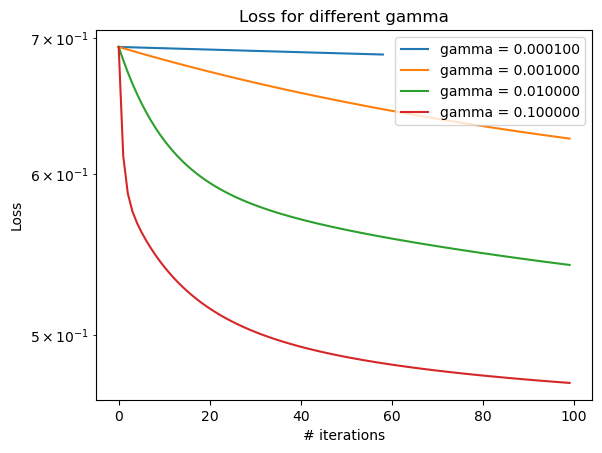

In [60]:
# Visualization
plot_loss_variable_param(logistic_gd_losses_var_gamma, learning_rate, 'gamma')

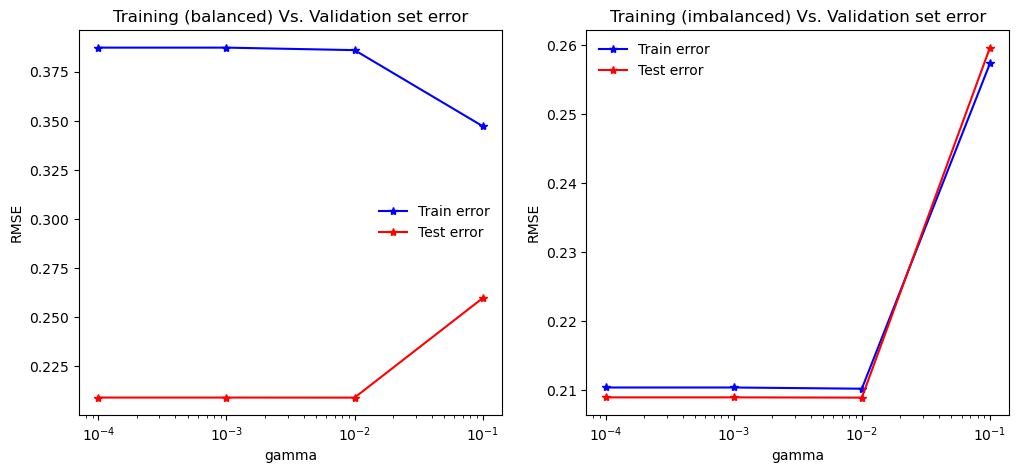

In [61]:
# Training (balanced) Vs. Validation error
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

rmse_validation = logistic_gd_rmse
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, logistic_gd_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

In [62]:
# Get optimal parameter and corresponding model weights, apply to test set
metrics = np.hstack([logistic_gd_f1_score.reshape(-1,1), logistic_gd_rmse.reshape(-1,1)])
metric_name = 'f1_score'

logistic_gd_opt_idx = hyperparam_optimization(metric_name, metrics, logistic_gd_ws_var_gamma, learning_rate, 'gamma', tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test, True)

The optimal parameter is gamma=0.100000 given optimization of the metric f1_score evaluating 0.33464.

The optimal weights are w = [[ 3.42864086e-02]
 [ 2.81902540e-02]
 [ 2.57973274e-02]
 [-7.56422442e-02]
 [ 1.86187343e-02]
 [-8.50857975e-02]
 [-2.88915178e-04]
 [ 5.38173054e-02]
 [ 4.96710738e-02]
 [ 3.09873654e-02]
 [ 2.02150732e-02]
 [ 2.50164247e-02]
 [-1.96436063e-02]
 [-5.35733276e-02]
 [ 8.99141046e-02]
 [ 8.85237711e-02]
 [ 1.39033350e-03]
 [-5.59572757e-02]
 [ 4.08870703e-02]
 [-1.21735195e-01]
 [ 7.29335053e-02]
 [-7.92274957e-02]
 [-2.42999050e-02]
 [ 3.90079480e-01]
 [ 5.61677881e-02]
 [-2.04502619e-01]
 [-3.58107434e-02]
 [ 6.31223210e-02]
 [-1.69511678e-01]
 [-7.78931421e-02]
 [-3.72865727e-02]
 [-2.06036396e-01]
 [-7.45825459e-02]
 [-5.06037329e-02]
 [-1.47026471e-01]
 [-2.16541947e-01]
 [ 1.66659665e-01]
 [-1.10433542e-01]
 [-2.12324147e-01]
 [-7.51513095e-02]
 [-6.76836658e-02]
 [-1.75476027e-01]
 [-3.81519983e-02]
 [-3.71198697e-02]
 [-1.61919586e-01]
 [-1.41777970e

In [63]:
highest_correlated_cat_feat, highest_correlated_cont_feat = highly_correlated_features(logistic_gd_losses_var_gamma[logistic_gd_opt_idx], feature_cat_map, feature_cont_map, categorical_features, continuous_features, duplicate_cats)
print('The categorical and continuous features with higher weights are respectively {}, {}.'.format(highest_correlated_cat_feat, highest_correlated_cont_feat))

The categorical and continuous features with higher weights are respectively _RFSEAT3, STRFREQ_.


#### Regularized Logistic Regression 

In [65]:
"""Regularized logistic regression"""

# Iterate over penalty parameter values 
reg_lr_f1_score = np.zeros((len(penalty), len(learning_rate)))
reg_lr_rmse = np.zeros((len(penalty), len(learning_rate)))

reg_lr_ws_var_lambda_and_gamma = []
reg_lr_losses_var_lambda_and_gamma = []

for idx_l, lambda_ in enumerate(penalty):

    for idx_g, gamma in enumerate(learning_rate):
    
        # Execute optimization algorithm, save losses and w at every iteration
        start_time = datetime.datetime.now()
        reg_logistic_losses, reg_logistic_ws = reg_logistic_regression(y_training_balanced, tx_training_balanced, w_initial, max_iters, gamma, lambda_)
        end_time = datetime.datetime.now()
        
        # Print excecution time
        execution_time = (end_time - start_time).total_seconds()
        print("Regularized logistic regression: gamma={g:.4f}, lambda={l:.6f}, execution time={t:.3f} seconds \n".format(g=gamma, l= lambda_, t=execution_time))
    
        # Compute accuracy metrics
        y_pred = tx_train_validation.dot(reg_logistic_ws[-1])
        y_pred = np.where(y_pred > threshold, 1, 0)
    
        tp, tn, fp, fn = confusion_matrix_metrics(y_train_validation, y_pred)
        f1_score = 2*tp/(2*tp + fp + fn)
        mse = calculate_mse(y_train_validation - y_pred)
        
        # Save losses, weights, accuracy metrics for hyperparameter optimization over learning rate
        reg_lr_f1_score[idx_l, idx_g] = f1_score
        reg_lr_rmse[idx_l, idx_g] = np.sqrt(mse)
    
        reg_lr_ws_var_lambda_and_gamma.append(reg_logistic_ws[-1].flatten())
        reg_lr_losses_var_lambda_and_gamma.append(reg_logistic_losses)

loss=0.6831728171880272
Regularized logistic regression: gamma=0.0001, lambda=0.000001, execution time=1.930 seconds 

loss=0.6246593237951014
Regularized logistic regression: gamma=0.0010, lambda=0.000001, execution time=1.802 seconds 

loss=0.5412188801629826
Regularized logistic regression: gamma=0.0100, lambda=0.000001, execution time=1.556 seconds 

loss=0.47340323209657825
Regularized logistic regression: gamma=0.1000, lambda=0.000001, execution time=1.632 seconds 

loss=0.6831728189294523
Regularized logistic regression: gamma=0.0001, lambda=0.000010, execution time=1.775 seconds 

loss=0.6246594277174219
Regularized logistic regression: gamma=0.0010, lambda=0.000010, execution time=1.676 seconds 

loss=0.541220111995836
Regularized logistic regression: gamma=0.0100, lambda=0.000010, execution time=1.793 seconds 

loss=0.47341334016369657
Regularized logistic regression: gamma=0.1000, lambda=0.000010, execution time=1.833 seconds 

loss=0.6831728363436771
Regularized logistic re

In [66]:
reg_lr_ws_var_lambda_and_gamma = np.reshape(reg_lr_ws_var_lambda_and_gamma, (len(penalty), len(learning_rate), len(w_initial)))
reg_lr_losses_var_lambda_and_gamma = np.reshape(reg_lr_losses_var_lambda_and_gamma, (len(penalty), len(learning_rate), max_iters))

In [67]:
# Get optimal parameter and corresponding model weights, apply to test set
metric_name = 'f1_score'
if metric_name == 'f1_score':
    metric = reg_lr_f1_score
    opt_index = np.argmax(reg_lr_f1_score)
elif metric_name == 'RMSE':
    metric = reg_lr_rmse
    opt_index = np.argmin(reg_lr_rmse)

# Convert this index to row and column indices
opt_row, opt_col = np.unravel_index(opt_index, metric.shape)

opt_lambda = penalty[opt_row]
opt_gamma = learning_rate[opt_col]
opt_w = reg_lr_ws_var_lambda_and_gamma[opt_row, opt_col]
opt_metric = metric[opt_row, opt_col]

print('The optimal parameters are lambda ={l:.6f} and gamma = {g:.6f} given optimization of the metric {metr} evaluating {m:.5f}.'.format(l = opt_lambda, g=opt_gamma, metr=metric_name, m=opt_metric))
print('The optimal weights are w = {}.'.format(opt_w))
print('f1 score = {f:.5f}, RMSE = {r:.5f}\n'.format(f=reg_lr_f1_score[opt_row, opt_col], r=reg_lr_rmse[opt_row, opt_col]))
print('*******************************\n')

print_report(opt_w, True, tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, tx_train_validation, y_train_validation, tx_test)

The optimal parameters are lambda =0.001000 and gamma = 0.100000 given optimization of the metric f1_score evaluating 0.33492.
The optimal weights are w = [ 3.36811046e-02  2.79163116e-02  2.55595675e-02 -7.55219433e-02
  1.86485190e-02 -8.48896575e-02 -1.95994914e-04  5.31873449e-02
  4.91157889e-02  3.07714884e-02  2.00613217e-02  2.47276700e-02
 -1.94900997e-02 -5.31648754e-02  8.89559790e-02  8.77097327e-02
  1.24624629e-03 -5.55961742e-02  4.02915756e-02 -1.21182256e-01
  7.22491195e-02 -7.85569173e-02 -2.40927176e-02  3.86642721e-01
  5.55801569e-02 -2.03158075e-01 -3.58318291e-02  6.26966268e-02
 -1.68219122e-01 -7.75541003e-02 -3.72906099e-02 -2.04675557e-01
 -7.41947895e-02 -5.04509554e-02 -1.46178330e-01 -2.15003723e-01
  1.65345537e-01 -1.09797965e-01 -2.10499569e-01 -7.47644168e-02
 -6.72875192e-02 -1.74211020e-01 -3.81476812e-02 -3.71364105e-02
 -1.60723026e-01 -1.42498563e-02 -1.57179009e-02 -7.93578105e-02
 -7.40766654e-03  3.81046070e-02  5.79773489e-02  3.54383071e-03


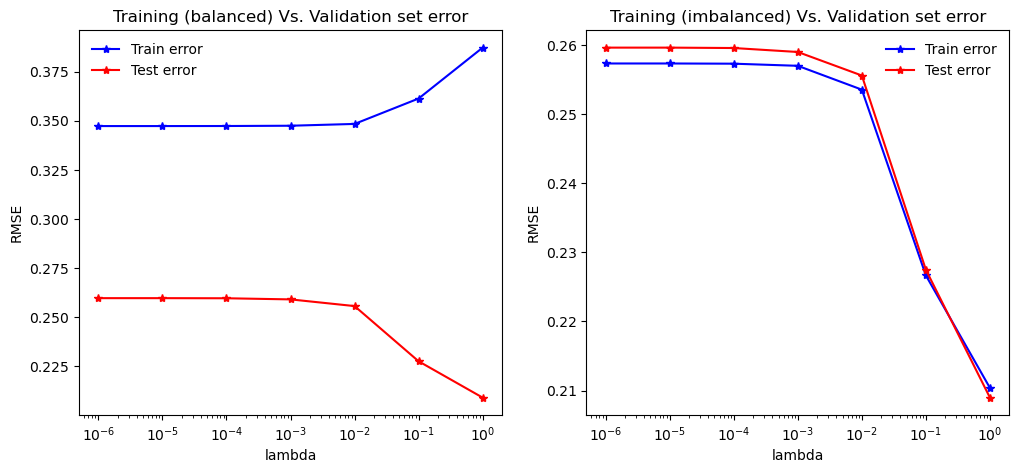

In [68]:
# Training (balanced) Vs. Validation error - penalty
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

reg_lr_ws_var_lambda = [reg_lr_ws_var_lambda_and_gamma[row, opt_col].reshape(-1,1) for row in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[0])]
rmse_validation = reg_lr_rmse[:,opt_col]
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, reg_lr_ws_var_lambda, penalty)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, penalty, 'lambda')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, penalty, 'lambda')

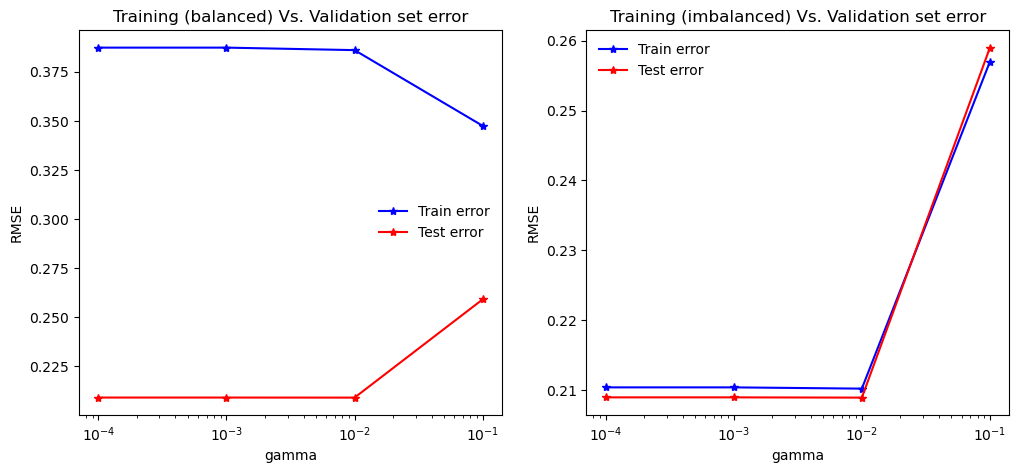

In [69]:
# Training (balanced) Vs. Validation error - learning rate
fig, axs = plt.subplots(1,2, figsize = (12,5))
axs = axs.flatten()

reg_lr_ws_var_gamma = [reg_lr_ws_var_lambda_and_gamma[opt_row, col].reshape(-1,1) for col in np.arange(np.shape(reg_lr_ws_var_lambda_and_gamma)[1])]
rmse_validation = reg_lr_rmse[opt_row, :]
rmse_training_balanced, rmse_training_imbalanced = train_vs_valid(tx_training_balanced, y_training_balanced, tx_train_training, y_train_training, reg_lr_ws_var_gamma, learning_rate)
plot_train_test(axs[0], "Training (balanced) Vs. Validation set error", rmse_training_balanced, rmse_validation, learning_rate, 'gamma')
plot_train_test(axs[1], "Training (imbalanced) Vs. Validation set error", rmse_training_imbalanced, rmse_validation, learning_rate, 'gamma')

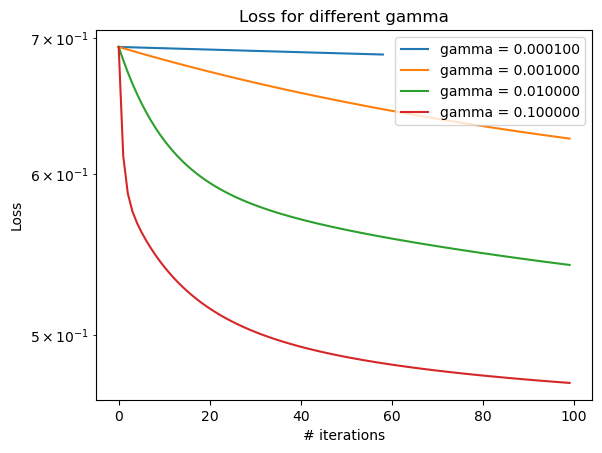

In [70]:
# Visualization
reg_lr_losses_var_gamma =  [reg_lr_losses_var_lambda_and_gamma[opt_row, col].reshape(-1,1) for col in np.arange(np.shape(reg_lr_losses_var_lambda_and_gamma)[1])]
plot_loss_variable_param(logistic_gd_losses_var_gamma, learning_rate, 'gamma')

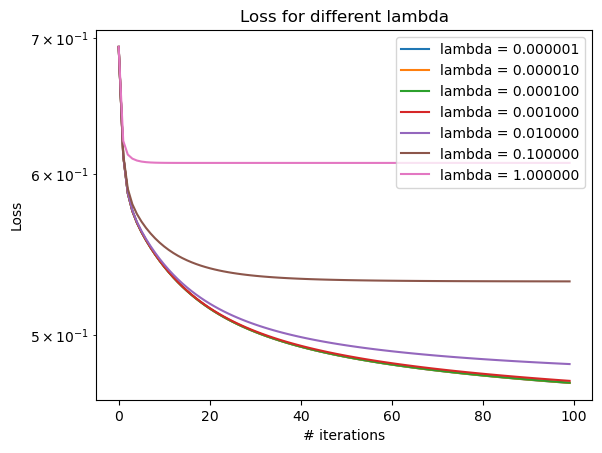

In [71]:
# Visualization
reg_lr_losses_var_lambda = [reg_lr_losses_var_lambda_and_gamma[row, opt_col].reshape(-1,1) for row in np.arange(np.shape(reg_lr_losses_var_lambda_and_gamma)[0])]
plot_loss_variable_param(reg_lr_losses_var_lambda, penalty, 'lambda')

In [72]:
highest_correlated_cat_feat, highest_correlated_cont_feat = highly_correlated_features(opt_w, feature_cat_map, feature_cont_map, categorical_features, continuous_features, duplicate_cats)
print('The categorical and continuous features with higher weights are respectively {}, {}.'.format(highest_correlated_cat_feat, highest_correlated_cont_feat))

The categorical and continuous features with higher weights are respectively _RFHYPE5, BEANDAY_.
